Datetime
2010-01-31 22:00    0.733
2010-01-31 22:00   -0.233
2010-01-31 22:00    0.733
2010-01-31 22:00   -0.233
2010-01-31 22:00    0.733
                    ...  
2020-10-22 21:00    0.119
2020-10-25 21:00   -0.425
2020-10-26 21:00   -0.094
2020-10-27 21:00    0.300
2020-10-28 21:00    0.013
Name: Rate, Length: 7446, dtype: float64
Low/Mid/High
[2640, 1840, 2966]
0.784656796769852
[[433  24  88]
 [ 49 248  54]
 [ 82  23 485]]
[0.7677305  0.84067797 0.77352472]
WIN RATE: 0.7707808564231738
553.2


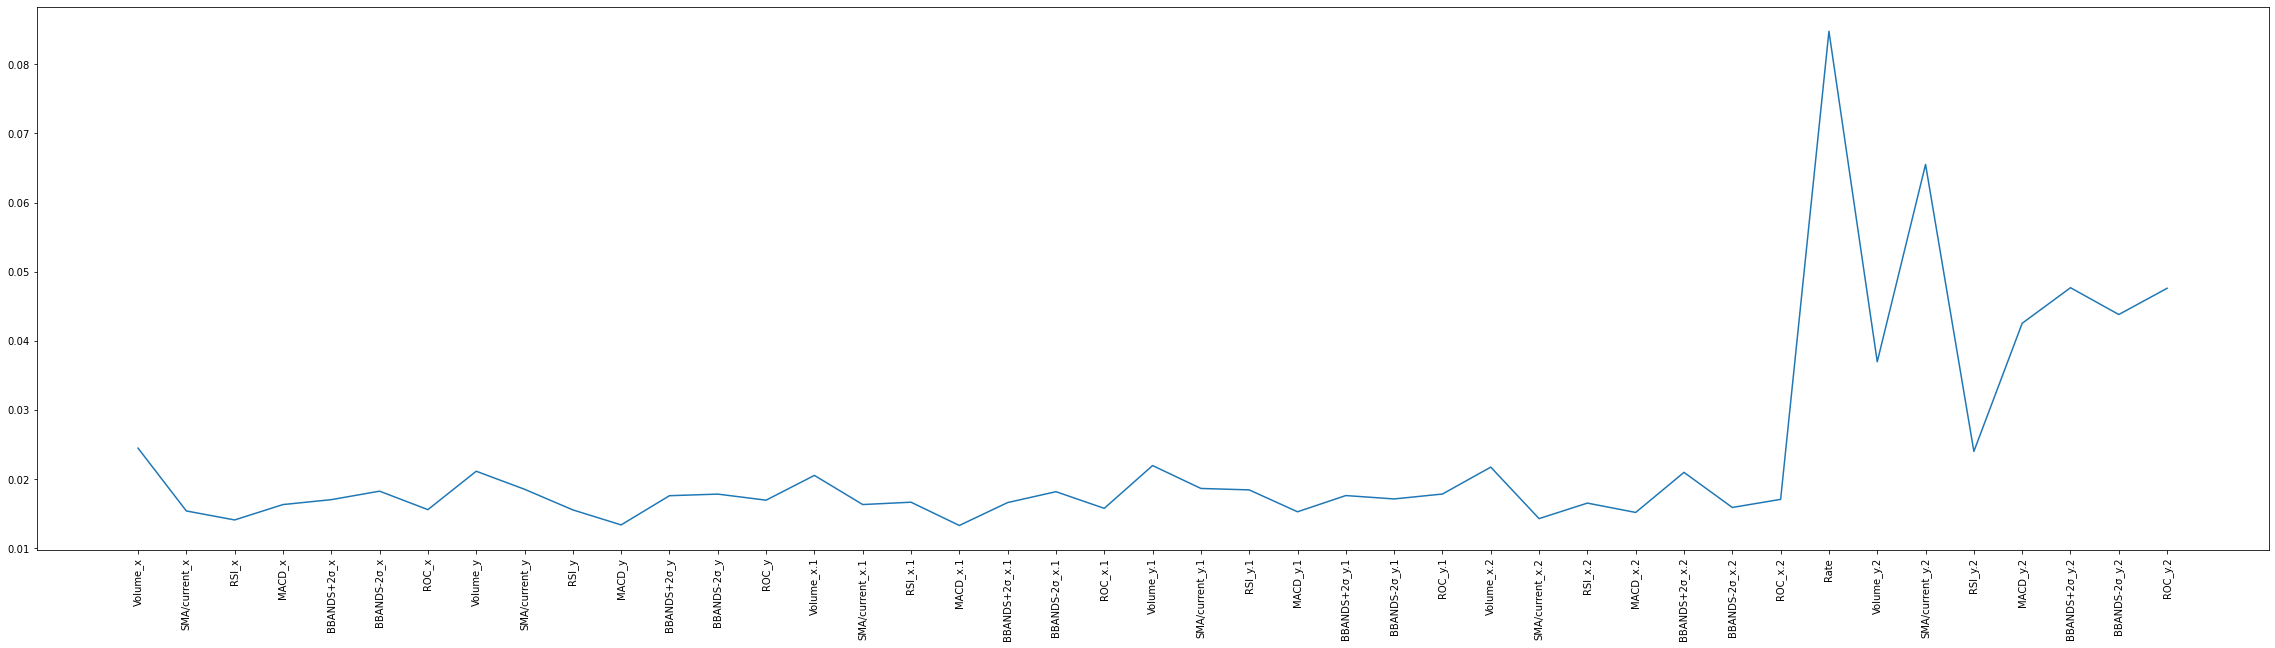

In [27]:
# series_H1.csv (3日分のデータを横並びにしたcsv) 専用　テクニカル分析は済んでいるのでコメントアウト

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import talib as ta

def adjust_data(dataname):
    df = pd.read_csv(dataname, index_col='Datetime')
    print(df['Rate'])
    #以降全ての計算でレート終値を使う

    
    c=[0,0,0]
    R=0.1

    # High,Mid,Low分類
    def classify(x):
        if x<=-R:
            c[0]+=1
            return 0
        elif -R<x<R:
            c[1]+=1
            return 1
        elif R<=x:
            c[2]+=1
            return 2
    
    
    
    
#     c=[0,0]

#     # High,Low分類
#     def classify(x):
#         if x<=0:
#             c[0]+=1
#             return 0
#         elif 0<x:
#             c[1]+=1
#             return 1
        
    classified = pd.DataFrame(columns=["class"])  #分類結果を格納
    classified["class"] = (df["Rate"]).apply(lambda x: classify(x))
    
    shift = 1
    
    classified = classified.shift(-shift)  #分類結果をずらす

    df_adjusted=df[0:len(df)-20]
    classified=classified[0:len(classified)-20]
    
    import math
    
    print("Low/Mid/High")
    print(c)
    return df_adjusted, classified

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna


#df_adjusted, classified = adjust_data("./20101to20209_USD_JPY_H1.csv")
df_adjusted, classified = adjust_data("20101to202010_USD_JPY_D_series.csv")
X_train, X_test, y_train, y_test = train_test_split(df_adjusted, classified["class"], train_size=0.8)
#print(X_train, y_train)



# def objective(trial):
#     min_samples_split = trial.suggest_int("min_samples_split", 8, 16)
#     max_leaf_nodes = int(trial.suggest_discrete_uniform("max_leaf_nodes", 4, 64, 4))
#     criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    
#     clf = RandomForestClassifier(min_samples_split = min_samples_split, 
#                                 max_leaf_nodes = max_leaf_nodes,
#                                 criterion = criterion)
#     clf.fit(X_train, y_train)
#     return 1.0 - accuracy_score(y_test, clf.predict(X_test))


# study = optuna.create_study()
# study.optimize(objective, n_trials = 100)


# print(study.best_params) # 求めたハイパーパラメータ
# print(1.0 - study.best_value) # 正答率


#clf = RandomForestClassifier(min_samples_split=11, max_leaf_nodes=20, criterion='entropy')
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
result = clf.predict(X_test)

print(accuracy_score(y_test, result))

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, result))

from sklearn.metrics import precision_score
print(precision_score(y_test, result, average=None))

import pickle
filename = 'RF_01.sav'
pickle.dump(clf, open(filename, 'wb'))

win = 0
lose = 0
for i in range(len(result)):
    if (result[i]==0):#Low予想のとき
        if (result[i]==y_test[i]): #予測成功
            win += 1
        else:
            lose +=1
    elif(result[i]==2):#High予想の時
        if (result[i]==y_test[i]): #予測成功
            win += 1
        else:
            lose +=1
    else:
        #print("ERROR")
        continue

print("WIN RATE: ",end='')
print(win/(win+lose))
print(win*0.9-lose)
            
            
plt.figure(figsize=(40,10))
plt.plot(df_adjusted.columns.values, clf.feature_importances_)
plt.xticks(rotation=90)
plt.show()



